In [80]:
import gizmo_analysis as gizmo
import utilities as ut

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import glob

import sys
sys.path.insert(0, '../util/')
from util_os import util_os
from util_galaxies import util_galaxies

In [4]:
dpath = '/data/groups/leauthaud/yluo42/FIRE/'

In [5]:
simfiles = glob.glob(dpath+'/m*')

In [6]:
simfiles

['/data/groups/leauthaud/yluo42/FIRE/m11b_r2100',
 '/data/groups/leauthaud/yluo42/FIRE/m11e_r7100',
 '/data/groups/leauthaud/yluo42/FIRE/m11h_r7100',
 '/data/groups/leauthaud/yluo42/FIRE/m11q_r880',
 '/data/groups/leauthaud/yluo42/FIRE/m11d_r7100',
 '/data/groups/leauthaud/yluo42/FIRE/m11i_r7100']

In [70]:
gal = simfiles[1]
particles = gizmo.io.Read.read_snapshots('all', 'redshift', 0, gal)


# in utilities.simulation.Snapshot():
* reading:  data/groups/leauthaud/yluo42/FIRE/m11e_r7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  data/groups/leauthaud/yluo42/FIRE/m11e_r7100/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 11213040 particles
    dark2     (id = 2): 3946497 particles
    gas       (id = 0): 10886907 particles
    star      (id = 4): 326376 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    data/groups/leauthaud/yluo42/FIRE/m11e_r7100/output/snapshot_600.hdf5

! cannot find MUSIC config file:  data/groups/leauthaud/yluo42/FIRE/m11e_r7100/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checki

In [71]:
particles.keys()

dict_keys(['dark', 'dark2', 'gas', 'star'])

In [72]:
particles['star'].keys()

dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'form.scalefactor', 'velocity'])

In [73]:
mass_allstars = particles['star'].prop('mass')
age_allstars = particles['star'].prop('age')
pos_allstars = particles['star'].prop('position')
vel_allstars = particles['star'].prop('host.velocity')

In [74]:
mass_allstars.shape

(326376,)

In [75]:
pos_allstars.shape

(326376, 3)

In [25]:
# DM center of mass
pos_DM = particles['dark'].prop('position')
mass_DM= particles['dark'].prop('mass')
com = np.sum(pos_DM * mass_DM[:, None], axis=0) / np.sum(mass_DM)

In [26]:
# make a cut for all particles within 2000 kpc of dark matter CoM
posmask = np.linalg.norm(pos_allstars-com, axis=1)<2000
mass_allstars = mass_allstars[posmask]
age_allstars = age_allstars[posmask]
pos_allstars = pos_allstars[posmask]
vel_allstars = vel_allstars[posmask]

In [27]:
pos_allstars.shape

(320264, 3)

In [28]:
com_star = np.sum(pos_allstars * mass_allstars[:, None], axis=0) / np.sum(mass_allstars)

posmask = np.linalg.norm(pos_allstars-com_star) < 100
mass_allstars = mass_allstars[posmask]
age_allstars = age_allstars[posmask]
pos_allstars = pos_allstars[posmask]
vel_allstars = vel_allstars[posmask]

# Spatial distro of particles

In [64]:
def compute_Rhalfmass_bisect(positions, masses, outerR, acc, maxiter=100000):
    innerLim = 0.0
    outerLim = outerR

    pRadii = np.linalg.norm(positions, ord=2, axis=1)
    mTot = sum(masses)

    r = outerR/2
    hm = sum(masses[pRadii < r])
    n=0
    while(hm < (0.50-acc)*mTot or hm > (0.5+acc)*mTot):
        if hm > 0.5*mTot: # too big, decrease r
            outerLim = r
            r = innerLim + (outerLim-innerLim)/2
        elif hm < 0.5*mTot: # too small, increase r
            innerLim = r
            r = innerLim + (outerLim-innerLim)/2
        hm = sum(masses[pRadii < r])

        n += 1
        if n>maxiter:
            return -1
            break

    return r

In [76]:
mass_allstars.shape

(326376,)

In [77]:
pos_allstars.shape

(326376, 3)

In [90]:
mass_allstars = particles['star'].prop('mass')
age_allstars = particles['star'].prop('age')
pos_allstars = particles['star'].prop('position')
vel_allstars = particles['star'].prop('host.velocity')

pos_alldm = particles['dark'].prop('position')
mass_alldm= particles['dark'].prop('mass')

# DM center of mass
com = np.sum(pos_alldm * mass_alldm[:, None], axis=0) / np.sum(mass_alldm)

pos_allstars -= com
pos_alldm -= com 

# cut by within 2000 kpc of com 
starmask = np.linalg.norm(pos_allstars, axis=1)<500
pos_allstars = pos_allstars[starmask]
mass_allstars = mass_allstars[starmask]

dmmask = np.linalg.norm(pos_alldm, axis=1)<2000
pos_alldm = pos_alldm[dmmask]

In [95]:
# star center of mass
com_star = np.sum(pos_allstars * mass_allstars[:, None], axis=0) / np.sum(mass_allstars)

hmr = compute_Rhalfmass_bisect(pos_allstars-com_star, mass_allstars, 1000, 0.01)

(-200.0, 200.0)

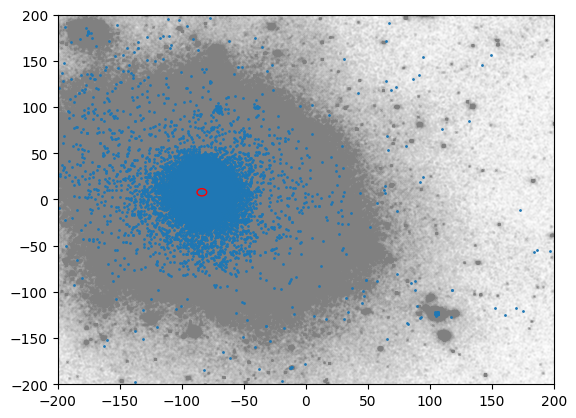

In [99]:
fig, ax = plt.subplots(1,1)

plt.scatter(pos_alldm[:,0], pos_alldm[:,1], s=1, c='grey', alpha=0.01)
plt.scatter(pos_allstars[:,0], pos_allstars[:,1], s=1)

c1 = matplotlib.patches.Circle(radius=hmr, xy=(com_star[0],com_star[1]), ec='r', fill=False)

ax.add_patch(c1)

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

In [97]:
hmr

3.90625

## parsing redshifts for snapshot

In [11]:
gal

'/data/groups/leauthaud/yluo42/FIRE/m11e_r7100'

In [19]:
zfile = '/data/groups/leauthaud/yluo42/FIRE/m11b_r2100/snapshot_times.txt'
simtimes = pd.read_csv(zfile, sep='\s+', skiprows=6, header=None)

st_tskey = 0
st_zkey = 2
st_tkey = 3
st_lbkey = 4

redshifts = np.flip(simtimes[st_zkey].to_numpy())

In [20]:
redshifts

array([0.00000000e+00, 1.59264000e-04, 3.18646000e-04, 4.77910000e-04,
       6.37293000e-04, 7.96795000e-04, 9.56297000e-04, 1.11579900e-03,
       1.27553900e-03, 1.43516100e-03, 1.59490100e-03, 3.19480900e-03,
       4.79996200e-03, 6.41024100e-03, 8.02576500e-03, 9.64629700e-03,
       1.12720730e-02, 1.29032140e-02, 1.45395990e-02, 1.61812310e-02,
       1.78282260e-02, 1.94805860e-02, 2.11381910e-02, 2.28012800e-02,
       2.44698520e-02, 2.61437890e-02, 2.78233290e-02, 2.95081140e-02,
       3.11987400e-02, 3.28947310e-02, 3.45964430e-02, 3.63035200e-02,
       3.80165580e-02, 3.97350790e-02, 4.14594410e-02, 4.31894060e-02,
       4.49250940e-02, 4.66667410e-02, 4.84139920e-02, 5.01672030e-02,
       5.19263740e-02, 5.36912680e-02, 5.54622410e-02, 5.72390560e-02,
       5.90219500e-02, 6.08108040e-02, 6.26057390e-02, 6.44068720e-02,
       6.62139650e-02, 6.80272580e-02, 6.98466300e-02, 7.16723200e-02,
       7.35042100e-02, 7.53425360e-02, 7.71870610e-02, 7.90377860e-02,
      

In [25]:
gal[-10:]

'm11b_r2100'

In [21]:
for z in redshifts:
    parts = gizmo.io.Read.read_snapshots('all', 'redshift', z, gal)


# in utilities.simulation.Snapshot():
* reading:  data/groups/leauthaud/yluo42/FIRE/m11b_r2100/snapshot_times.txt

* input redshift = 0.0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  data/groups/leauthaud/yluo42/FIRE/m11b_r2100/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 22374200 particles
    dark2     (id = 2): 19623813 particles
    gas       (id = 0): 22336883 particles
    star      (id = 4): 37213 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    data/groups/leauthaud/yluo42/FIRE/m11b_r2100/output/snapshot_600.hdf5

! cannot find MUSIC config file:  data/groups/leauthaud/yluo42/FIRE/m11b_r2100/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* chec

KeyboardInterrupt: 

## 3 panel figure
Need:
 * sigma
 * SSFR 
 * half mass radius

In [43]:
# use this for sSFR
particles['star'].prop('age')
masses = particles['star'].prop('mass')

In [41]:
# can calculate half mass radius here
starpos = particles['star'].prop('position')

In [28]:
# velocities
velocities_rad = particles['star'].prop('host.velocity.principal.spherical')[:, 0]  # radial velocity

velocities_3d = particles['star'].prop('host.velocity')

In [26]:
# Yifei's code for mass weighted 3D velocity distribution
def compute_vdisp(velocities, masses):
    center_of_mass_velocity = np.sum(velocities * masses[:, None], axis=0) / np.sum(masses)
    velocity_differences = velocities - center_of_mass_velocity
    velocity_differences_squared = np.sum(velocity_differences**2, axis=1)
    mass_weighted_dispersion = np.sqrt(np.sum(velocity_differences_squared * masses) / np.sum(masses))
    return mass_weighted_dispersion

In [60]:
#  mass weighted radial velocity distribytion
def compute_vdisp_rad(velocities, masses):
    center_of_mass_velocity = np.sum(velocities * masses, axis=0) / np.sum(masses)
    velocity_differences = velocities - center_of_mass_velocity
    velocity_differences_squared = np.sum(velocity_differences**2, axis=0)
    mass_weighted_dispersion = np.sqrt(np.sum(velocity_differences_squared * masses) / np.sum(masses))
    #return center_of_mass_velocity
    return mass_weighted_dispersion

In [33]:
velocities_3d

array([[  41.284645 ,   14.041922 ,   32.112816 ],
       [  -7.9162774,   -3.7507262,   10.986878 ],
       [ -41.625034 ,  -50.93744  ,   29.438032 ],
       ...,
       [ -27.491978 ,  -35.202248 ,   26.35589  ],
       [ -29.708197 ,  -38.479324 ,   30.914165 ],
       [-113.45388  , -166.52464  ,  -33.670742 ]], dtype=float32)

In [37]:
velocities_3d[:,1]

array([  14.041922 ,   -3.7507262,  -50.93744  , ...,  -35.202248 ,
        -38.479324 , -166.52464  ], dtype=float32)

In [78]:
# positions are 3D 
def compute_Rhalfmass(positions, masses, startR, incBy, acc):
    center_of_mass = np.sum(positions * masses[:, None], axis=0) / np.sum(masses)
    correctedpos = positions-center_of_mass
    
    radii = np.linalg.norm(correctedpos, ord=2, axis=1)
    mTot = np.sum(masses)
    
    # start at startR and increment 
    r = startR - incBy
    hm = mTot
    while(hm < (0.50-acc)*mTot or hm > (0.5+acc)*mTot):
        r+=incBy
        hm = np.sum(masses[radii < r])
        
        # check bounds 
        if (r>max(radii)):
            return -1
    
    return r

In [67]:
center_of_mass = np.sum(starpos * masses[:, None], axis=0) / np.sum(masses)
radii = np.linalg.norm(starpos-center_of_mass, ord=2, axis=1)

In [71]:
max(radii)

3373.96459972014

In [83]:
compute_Rhalfmass(starpos, masses, startR=38, incBy=0.01, acc=0.01)

39.18999999999976

In [36]:
compute_vdisp(velocities_3d, masses)

51.041153

In [61]:
compute_vdisp_rad(velocities_rad, masses)

6910.5435

In [38]:
center_of_mass_velocity=1

In [46]:
velocities_3d*masses[:,None]

array([[  55686.234 ,   18940.256 ,   43314.938 ],
       [ -10330.108 ,   -4894.3975,   14336.996 ],
       [ -60441.023 ,  -73962.96  ,   42745.066 ],
       ...,
       [ -41837.312 ,  -53570.81  ,   40108.414 ],
       [ -45828.41  ,  -59358.914 ,   47688.76  ],
       [-161054.22  , -236391.19  ,  -47797.53  ]], dtype=float32)

In [48]:
velocities_rad*masses

array([-3.3153930e+04,  1.8547777e+02,  5.5631895e+04, ...,
        7.8504180e+04,  8.8510133e+04,  2.8962588e+05], dtype=float32)